# Numba func - C Callback function

This tutorial presents, how to set up a simple pipeline, that rotate images using numba_func operator.
This operator is a way for invoking user defined python code using DALI pipeline for allocating resources.

Operator is depending on Numba support https://numba.pydata.org/ which translate python and numpy code into LLVM code
which allows to reduce python interpreter overhead or completely eliminate it.

## Step-by-Step Guide
1. Let's start by importing DALI and a handful of utils.

In [1]:
from numba import cfunc, types, carray

from nvidia.dali import pipeline_def
import nvidia.dali as dali
import nvidia.dali.fn as fn
import nvidia.dali.types as dali_types
import nvidia.dali.numba_func as dali_numba

image_dir = "../data/images"
max_batch_size = 8

2. Next, we need to implement setup function for our operator. In setup function you are allowed to set output shapes basing on input shapes as well as set output data type. Note that the setup function is invoked once for the whole batch.

In [2]:
@cfunc(dali_numba.setup_fn_sig(1, 1), nopython=True)
def rot_image_setup(out_shape_ptr, out_ndim, out_dtype_ptr, in_shape_ptr, in_ndim, in_dtype, num_samples):
    in_shape = carray(in_shape_ptr, (num_samples, out_ndim))
    out_shape = carray(out_shape_ptr, (num_samples, in_ndim))
    out_type = carray(out_dtype_ptr, 1)
    out_type[0] = in_dtype
    for i in range(num_samples):
        out_shape[i][0]= in_shape[i][1]
        out_shape[i][1] = in_shape[i][0]
        out_shape[i][2] = in_shape[i][2]

To learn more about cfunc you should go straight to [numba documentation](https://numba.pydata.org/numba-doc/latest/user/cfunc.html).

`setup_fn_sig` provide a function signature. As an arguments it takes respectively number of outputs and inputs.
Definition of setup function with `n` outputs and `m` inputs looks as follows 
```
def setup_fn(out1_shape_ptr, out1_ndim, out1_dtype_ptr, ..., outn_shape_ptr, outn_ndim, outn_dtype_ptr \
    in1_shape_ptr, in1_ndim, in1_dtype, ..., inm_shape_ptr, inm_ndim, inm_dtype, num_samples):
```
So firstly we have all arguments connected with `n` outputs, then `m` inputs arguments and at the end number of sumples in batch.

3. Now we need to implement run method which will rotate images.

In [3]:
@cfunc(dali_numba.run_fn_sig(types.uint8, types.uint8), nopython=False)
def rot_image(out_ptr, out_shape_ptr, ndim_out, in_ptr, in_shape_ptr, ndim_in):
    out_shape = carray(out_shape_ptr, ndim_out)
    in_shape = carray(in_shape_ptr, ndim_in)
    in_arr = carray(in_ptr, (in_shape[0], in_shape[1], in_shape[2]))
    out_arr = carray(out_ptr, (out_shape[0], out_shape[1], out_shape[2]))
    for i in range(out_shape[0]):
        for j in range(out_shape[1]):
            out_arr[i][j] = in_arr[j][out_shape[0] - i - 1]

`run_fn_sig([output_numba_types], [input_numba_types])` provide a signature for run function. You can specify `n` outputs and `m` inputs. Then the run function should have following definition:
```
def run_fn(out1_ptr, out1_shape_ptr, ndim_out1, ..., outn_ptr, outn_shape_ptr, ndim_outm, \
    in1_ptr, in1_shape_ptr, ndim_in1, ..., inm_ptr, inm_shape_ptr, ndim_inm):
```
As you can see we don't specify number of samples in batch. That's because this function is run on a per-sample basis.

Note: Please remember passing incorrect outputs and inputs types to `run_fn_sig` will result in unexpected behaviour.

4. Define pipeline for reading images and invoking numba_func operator

In [4]:
@pipeline_def
def rotate_image_pipe(fn_ptr=None, setup_fn=None):
    files, labels = fn.readers.file(file_root=image_dir)
    images_in = dali.fn.decoders.image(files, device="cpu")
    return images_in, dali.fn.experimental.numba_func(images_in, fn_ptr=fn_ptr, setup_fn=setup_fn)

If you want to know more about readers and decoders you should read [Getting Started](https://github.com/NVIDIA/DALI/blob/master/docs/examples/getting%20started.ipynb) notebook.

5. Lets build and run pipeline

In [5]:
pipe = rotate_image_pipe(batch_size=max_batch_size, num_threads=1, device_id=0, fn_ptr=rot_image.address, setup_fn=rot_image_setup.address)
pipe.build()
images_in, images_out = pipe.run()

In [6]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

def show_images(image_batch):
    columns = 4
    rows = (max_batch_size + 1) // (columns)
    fig = plt.figure(figsize = (32,(32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j))

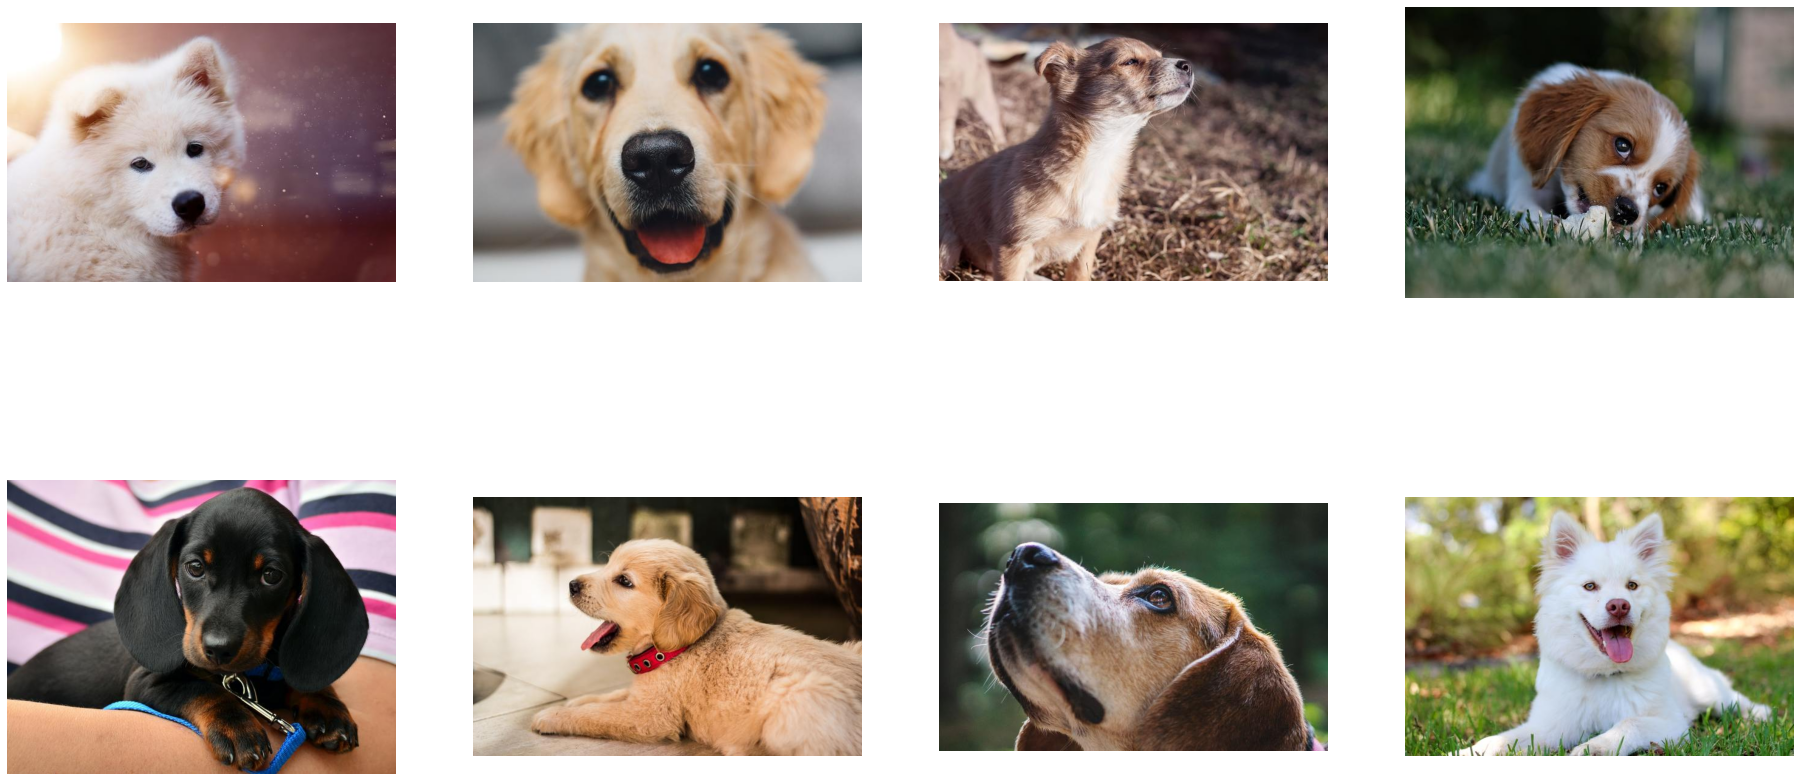

In [7]:
show_images(images_in)

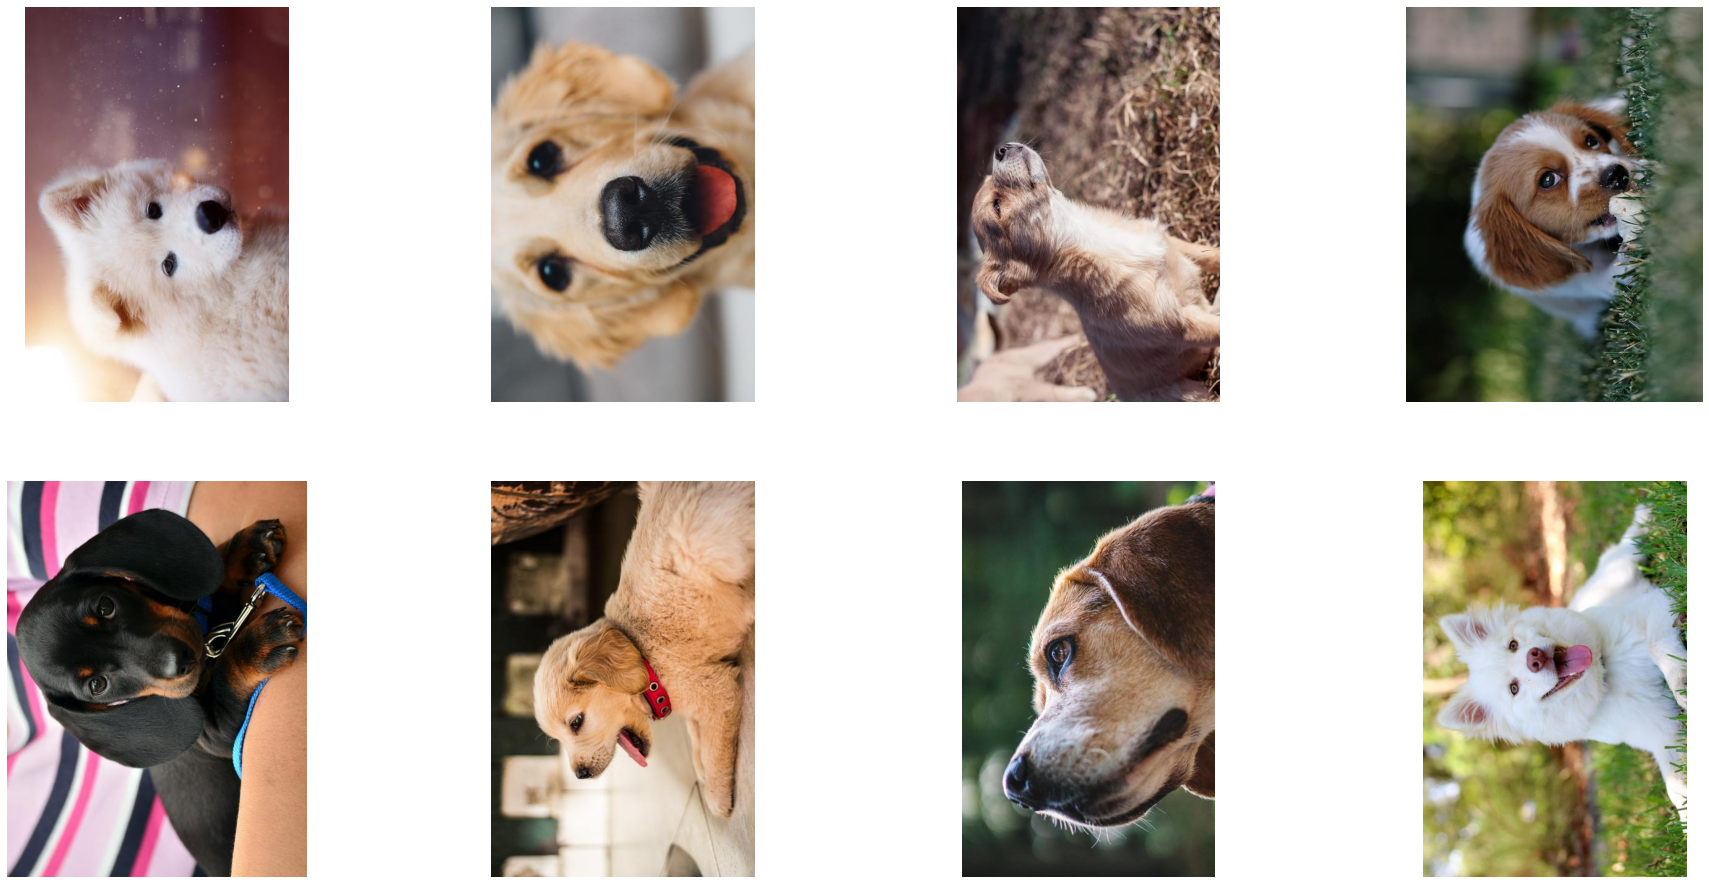

In [8]:
show_images(images_out)